In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [85]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, Add, Input, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom  # For resizing images

# Modify paths to point to your dataset in Google Drive
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Load file names
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

# Split data (train/test) - same split as V-Net
train_img, test_img, train_lbl, test_lbl = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Define target shape for resizing - same as V-Net
target_shape = (54, 54, 38)

In [87]:
class NiftiDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, image_filenames, label_filenames, batch_size=2, target_shape=(54, 54, 38)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = image_filenames
        self.label_filenames = label_filenames
        self.batch_size = batch_size
        self.target_shape = target_shape

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for img_file, lbl_file in zip(batch_images, batch_labels):
            img_data = nib.load(os.path.join(self.image_dir, img_file)).get_fdata()
            lbl_data = nib.load(os.path.join(self.label_dir, lbl_file)).get_fdata()

            # Compute zoom factors for resizing
            img_zoom = [t / s for s, t in zip(img_data.shape, self.target_shape)]
            lbl_zoom = [t / s for s, t in zip(lbl_data.shape, self.target_shape)]

            img_resized = zoom(img_data, img_zoom, order=1)  # Bilinear interpolation for images
            lbl_resized = zoom(lbl_data, lbl_zoom, order=0)  # Nearest-neighbor for labels

            images.append(img_resized[..., np.newaxis])  # Add channel dim
            labels.append((lbl_resized > 0).astype(np.uint8)[..., np.newaxis])  # Convert to binary mask

        return np.array(images), np.array(labels)

# Initialize generators with resized data
batch_size = 2
train_generator = NiftiDataGenerator(image_path, label_path, train_img, train_lbl, batch_size, target_shape)
test_generator = NiftiDataGenerator(image_path, label_path, test_img, test_lbl, batch_size, target_shape)


In [88]:
# Define HDC-Net architecture
def hybrid_dilated_conv_block(x, filters, dilation_rates=[1, 2, 4]):
    """Hybrid Dilated Convolution block with multiple dilation rates"""
    # Store the input for residual connection
    residual = x
    
    # Apply BatchNormalization for better training
    x = BatchNormalization()(x)
    
    # Multiple parallel dilated convolutions
    dilated_outputs = []
    for rate in dilation_rates:
        dilated_conv = Conv3D(filters // len(dilation_rates), 
                              kernel_size=(3, 3, 3),
                              dilation_rate=(rate, rate, rate),
                              padding='same',
                              activation='relu')(x)
        dilated_outputs.append(dilated_conv)
    
    # Concatenate the outputs from different dilation rates
    x = Concatenate()(dilated_outputs)
    
    # Project back to original number of filters
    x = Conv3D(filters, kernel_size=(1, 1, 1), padding='same', activation='relu')(x)
    
    # Add residual connection
    if residual.shape[-1] != filters:
        residual = Conv3D(filters, kernel_size=(1, 1, 1), padding='same')(residual)
    
    return Add()([x, residual])

In [90]:

def build_3d_hdc_net(input_shape=(54, 54, 38, 1)):
    """Build the 3D HDC-Net model with proper shape management"""
    inputs = Input(input_shape)
    
    # Initial convolution
    x = Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputs)
    
    # Encoder path with HDC blocks
    # Stage 1
    enc1 = hybrid_dilated_conv_block(x, 16, dilation_rates=[1, 2, 3])
    # Downsample
    pool1 = Conv3D(32, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(enc1)
    
    # Stage 2
    enc2 = hybrid_dilated_conv_block(pool1, 32, dilation_rates=[1, 2, 5])
    # Downsample
    pool2 = Conv3D(64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(enc2)
    
    # Stage 3 (Bottleneck)
    bottleneck = hybrid_dilated_conv_block(pool2, 64, dilation_rates=[1, 2, 4, 8])
    bottleneck = Dropout(0.3)(bottleneck)  # Add dropout for regularization
    
    # Decoder path
    # Stage 3 - Ensure proper upsampling by using output_padding if needed
    dec3 = Conv3DTranspose(32, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(bottleneck)
    
    # Get shape information for debugging
    print(f"enc2 shape: {enc2.shape}, dec3 shape: {dec3.shape}")
    
    # Ensure shapes match before concatenation - use cropping or padding if necessary
    if dec3.shape[1:4] != enc2.shape[1:4]:
        # Option 1: Use a reshape layer or custom cropping
        pad_h = enc2.shape[1] - dec3.shape[1] if enc2.shape[1] > dec3.shape[1] else 0
        pad_w = enc2.shape[2] - dec3.shape[2] if enc2.shape[2] > dec3.shape[2] else 0
        pad_d = enc2.shape[3] - dec3.shape[3] if enc2.shape[3] > dec3.shape[3] else 0
        
        if pad_h > 0 or pad_w > 0 or pad_d > 0:
            dec3 = tf.keras.layers.ZeroPadding3D(padding=((0, pad_h), (0, pad_w), (0, pad_d)))(dec3)
        
        crop_h = dec3.shape[1] - enc2.shape[1] if dec3.shape[1] > enc2.shape[1] else 0
        crop_w = dec3.shape[2] - enc2.shape[2] if dec3.shape[2] > enc2.shape[2] else 0
        crop_d = dec3.shape[3] - enc2.shape[3] if dec3.shape[3] > enc2.shape[3] else 0
        
        if crop_h > 0 or crop_w > 0 or crop_d > 0:
            dec3 = tf.keras.layers.Cropping3D(cropping=((0, crop_h), (0, crop_w), (0, crop_d)))(dec3)
    
    # Concatenate skip connection after ensuring shapes match
    dec3 = Concatenate()([dec3, enc2])
    dec3 = hybrid_dilated_conv_block(dec3, 32, dilation_rates=[1, 2, 4])
    
    # Stage 2
    dec2 = Conv3DTranspose(16, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(dec3)
    
    # Ensure shapes match for second concatenation
    print(f"enc1 shape: {enc1.shape}, dec2 shape: {dec2.shape}")
    
    if dec2.shape[1:4] != enc1.shape[1:4]:
        # Option 1: Use a reshape layer or custom cropping
        pad_h = enc1.shape[1] - dec2.shape[1] if enc1.shape[1] > dec2.shape[1] else 0
        pad_w = enc1.shape[2] - dec2.shape[2] if enc1.shape[2] > dec2.shape[2] else 0
        pad_d = enc1.shape[3] - dec2.shape[3] if enc1.shape[3] > dec2.shape[3] else 0
        
        if pad_h > 0 or pad_w > 0 or pad_d > 0:
            dec2 = tf.keras.layers.ZeroPadding3D(padding=((0, pad_h), (0, pad_w), (0, pad_d)))(dec2)
        
        crop_h = dec2.shape[1] - enc1.shape[1] if dec2.shape[1] > enc1.shape[1] else 0
        crop_w = dec2.shape[2] - enc1.shape[2] if dec2.shape[2] > enc1.shape[2] else 0
        crop_d = dec2.shape[3] - enc1.shape[3] if dec2.shape[3] > enc1.shape[3] else 0
        
        if crop_h > 0 or crop_w > 0 or crop_d > 0:
            dec2 = tf.keras.layers.Cropping3D(cropping=((0, crop_h), (0, crop_w), (0, crop_d)))(dec2)
    
    dec2 = Concatenate()([dec2, enc1])
    dec2 = hybrid_dilated_conv_block(dec2, 16, dilation_rates=[1, 2, 3])
    
    # Final convolution
    final = Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu')(dec2)
    outputs = Conv3D(1, kernel_size=(1, 1, 1), activation='sigmoid')(final)
    
    # Build and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

# Alternative implementation with simpler architecture to avoid shape issues
def build_3d_hdc_net_simple(input_shape=(54, 54, 38, 1)):
    """Build a simpler 3D HDC-Net model to avoid shape issues"""
    inputs = Input(input_shape)
    
    # Initial convolution
    x = Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputs)
    
    # Encoder path
    enc1 = hybrid_dilated_conv_block(x, 16, dilation_rates=[1, 2, 3])
    pool1 = Conv3D(32, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(enc1)
    
    enc2 = hybrid_dilated_conv_block(pool1, 32, dilation_rates=[1, 2, 5])
    pool2 = Conv3D(64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu')(enc2)
    
    # Bottleneck
    bottleneck = hybrid_dilated_conv_block(pool2, 64, dilation_rates=[1, 2, 4, 8])
    bottleneck = Dropout(0.3)(bottleneck)
    
    # Decoder path
    up1 = Conv3DTranspose(32, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(bottleneck)
    concat1 = Concatenate(axis=-1)([up1, enc2])  # Skip connection with enc2
    dec1 = hybrid_dilated_conv_block(concat1, 32, dilation_rates=[1, 2, 4])
    
    up2 = Conv3DTranspose(16, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(dec1)
    concat2 = Concatenate(axis=-1)([up2, enc1])  # Skip connection with enc1
    dec2 = hybrid_dilated_conv_block(concat2, 16, dilation_rates=[1, 2, 3])
    
    # Output layer
    outputs = Conv3D(1, kernel_size=(1, 1, 1), activation='sigmoid')(dec2)
    
    # Build and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

# Build model with fixed input shape
print("Building HDC-Net...")
try:
    # Try the more complex version first
    model = build_3d_hdc_net(input_shape=target_shape + (1,))
except ValueError as e:
    print(f"Error with complex model: {e}")
    print("Falling back to simpler model architecture...")
    model = build_3d_hdc_net_simple(input_shape=target_shape + (1,))


Building HDC-Net...
enc2 shape: (None, 27, 27, 19, 32), dec3 shape: (None, 28, 28, 20, 32)
enc1 shape: (None, 54, 54, 38, 16), dec2 shape: (None, 54, 54, 38, 16)


In [91]:

# Train model
print("Starting training...")
history = model.fit(train_generator, 
                   epochs=60, 
                   validation_data=test_generator,
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                   ])


Starting training...


C:\Users\Inayaimtiyaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7321 - loss: 7.5499 - precision_1: 0.0472 - recall_1: 0.5159 - val_accuracy: 0.9466 - val_loss: 0.9911 - val_precision_1: 0.0482 - val_recall_1: 0.0333
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9537 - loss: 0.8299 - precision_1: 0.0514 - recall_1: 0.0418 - val_accuracy: 0.9520 - val_loss: 0.6825 - val_precision_1: 0.0889 - val_recall_1: 0.0497
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9603 - loss: 0.5477 - precision_1: 0.0933 - recall_1: 0.0781 - val_accuracy: 0.9556 - val_loss: 0.4992 - val_precision_1: 0.1810 - val_recall_1: 0.0995
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9634 - loss: 0.4127 - precision_1: 0.1943 - recall_1: 0.1555 - val_accuracy: 0.9608 - val_loss: 0.3743 - val_precision_1: 0.3823 - val_recall_1: 0.3104
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9682 - loss: 0.3083 - precision_1: 0.3621 - recall_1: 0.3321 - val_accur

In [92]:
# Save the model to a file (in this case, in the current directory of Colab)
model.save(r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5")

print("Model saved successfully!")

Model saved successfully!


In [95]:
import numpy as np

def iou_score(y_true, y_pred, threshold=0.5):
    """Compute Intersection over Union (IoU)."""
    y_pred = (y_pred > threshold).astype(np.uint8)  # Convert probability map to binary mask
    y_true = (y_true > threshold).astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union > 0 else 1.0  # Avoid division by zero

def dice_score(y_true, y_pred, threshold=0.5):
    """Compute Dice Coefficient."""
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > threshold).astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) > 0 else 1.0

# Example: Evaluate on a single test image
y_true = np.random.randint(0, 2, (256, 256))  # Simulated ground truth
y_pred = np.random.rand(256, 256)  # Simulated model output (probability map)

iou = iou_score(y_true, y_pred)
dice = dice_score(y_true, y_pred)

print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")



IoU: 0.3352, Dice: 0.5021


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 54, 54,    │          0 │ -                 │
│ (InputLayer)        │ 38, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_32 (Conv3D)  │ (None, 54, 54,    │        448 │ input_layer_2[0]… │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │         64 │ conv3d_32[0][0]   │
│ (BatchNormalizatio… │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_33 (Conv3D)  │ (None, 54, 54,    │      2,165 │ batch_normalizat… │
│                     │ 38, 5)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_34 (Conv3D)  │ (None, 54, 54,    │      2,165 │ batch_normalizat… │
│                     │ 38, 5)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_35 (Conv3D)  │ (None, 54, 54,    │      2,165 │ batch_normalizat… │
│                     │ 38, 5)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 54, 54,    │          0 │ conv3d_33[0][0],  │
│ (Concatenate)       │ 38, 15)           │            │ conv3d_34[0][0],  │
│                     │                   │            │ conv3d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_36 (Conv3D)  │ (None, 54, 54,    │        256 │ concatenate_8[0]… │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 54, 54,    │          0 │ conv3d_36[0][0],  │
│                     │ 38, 16)           │            │ conv3d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_37 (Conv3D)  │ (None, 27, 27,    │     13,856 │ add_6[0][0]       │
│                     │ 19, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv3d_37[0][0]   │
│ (BatchNormalizatio… │ 19, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_38 (Conv3D)  │ (None, 27, 27,    │      8,650 │ batch_normalizat… │
│                     │ 19, 10)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_39 (Conv3D)  │ (None, 27, 27,    │      8,650 │ batch_normalizat… │
│                     │ 19, 10)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_40 (Conv3D)  │ (None, 27, 27,    │      8,650 │ batch_normalizat… │
│                     │ 19, 10)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 27, 27,    │          0 │ conv3d_38[0][0],  │
│ (Concatenate)       │ 19, 30)           │            │ conv3d_39[0][0],  │
│                     │                   │            │ conv3d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_41 (Conv3D)  │ (None, 27, 27,    │        992 │ concatenate_9[0]… │
│                     │ 19, 32)           │            │                 

 Total params: 363,821 (1.39 MB)

 Trainable params: 363,403 (1.39 MB)

 Non-trainable params: 416 (1.62 KB)

 Optimizer params: 2 (12.00 B)

Loading image: C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_0.nii
Loading label: C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_0.nii
Image shape: (180, 180, 125)
Label shape: (180, 180, 125)
Displaying slice viewer...


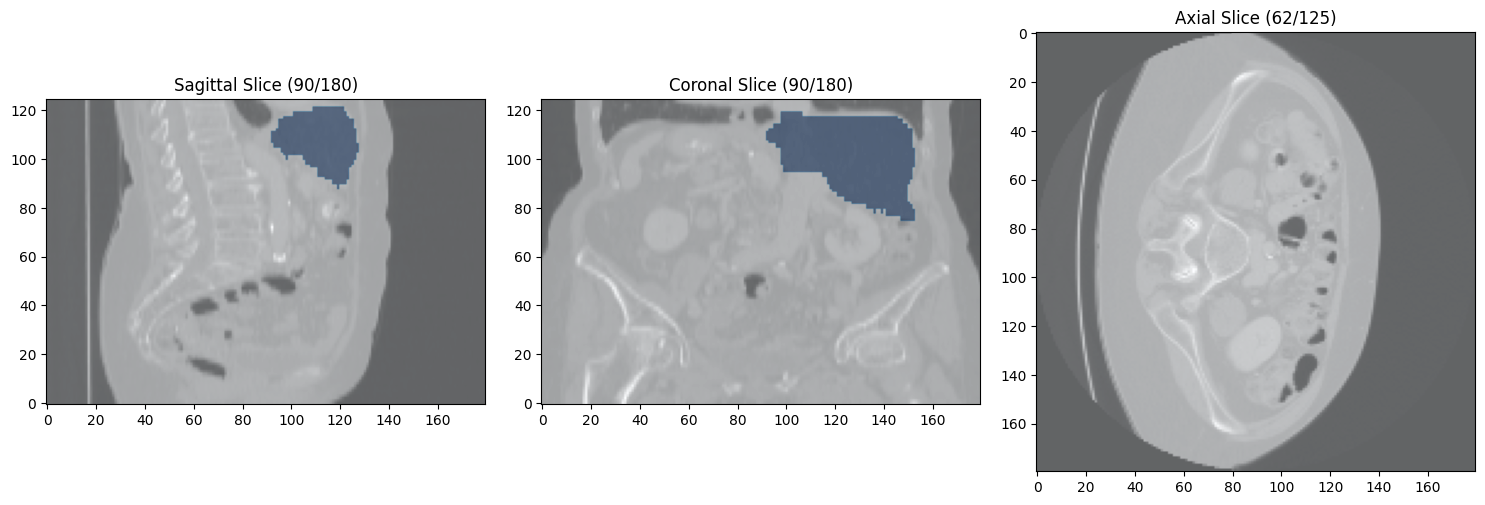

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
import os

def load_nifti(file_path):
    """Load a NIfTI file."""
    img = nib.load(file_path)
    return img.get_fdata()

def visualize_3d_surface(label_data, threshold=0.5):
    """Visualize a 3D surface from label data"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create binary mask and get coordinates of segmented regions
    mask = label_data > threshold
    x, y, z = np.where(mask)
    
    # Downsample points for better performance (if necessary)
    downsample_ratio = len(x) // 5000 + 1
    x = x[::downsample_ratio]
    y = y[::downsample_ratio]
    z = z[::downsample_ratio]
    
    # Plot the 3D surface
    ax.scatter(x, y, z, c='red', marker='.', alpha=0.2, s=1)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Visualization of Segmentation')
    
    plt.tight_layout()
    plt.show()

def visualize_3d_data(image_data, label_data):
    """Visualize a few slices of 3D image and overlay label"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Define middle slices for each axis
    x_slice = image_data.shape[0] // 2
    y_slice = image_data.shape[1] // 2
    z_slice = image_data.shape[2] // 2
    
    # Normalize image for better display
    norm_image = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Display slices along each axis
    axes[0].imshow(norm_image[x_slice, :, :].T, cmap='gray', origin="lower")
    axes[1].imshow(norm_image[:, y_slice, :].T, cmap='gray', origin="lower")
    axes[2].imshow(norm_image[:, :, z_slice], cmap='gray')
    
    # Overlay the segmentation mask
    axes[0].imshow(label_data[x_slice, :, :].T, cmap='Blues', alpha=0.4, origin="lower")
    axes[1].imshow(label_data[:, y_slice, :].T, cmap='Blues', alpha=0.4, origin="lower")
    axes[2].imshow(label_data[:, :, z_slice], cmap='Blues', alpha=0.4)

    axes[0].set_title(f'Sagittal Slice ({x_slice}/{image_data.shape[0]})')
    axes[1].set_title(f'Coronal Slice ({y_slice}/{image_data.shape[1]})')
    axes[2].set_title(f'Axial Slice ({z_slice}/{image_data.shape[2]})')
    
    plt.tight_layout()
    plt.show()

def visualize_liver_dataset(image_file, label_file):
    """Load and visualize a liver image and its segmentation"""
    print(f"Loading image: {image_file}")
    image_data = load_nifti(image_file)
    
    print(f"Loading label: {label_file}")
    label_data = load_nifti(label_file)
    
    print("Image shape:", image_data.shape)
    print("Label shape:", label_data.shape)
    
    # Visualize slices with label overlay
    print("Displaying slice viewer...")
    visualize_3d_data(image_data, label_data)
    
    # Optionally visualize 3D surface (may be slow for large volumes)
    response = input("Would you like to visualize the 3D surface? (y/n): ")
    if response.lower() == 'y':
        print("Generating 3D surface visualization...")
        visualize_3d_surface(label_data)

# File paths (modify according to your actual paths)
image_file = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_0.nii"
label_file = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_0.nii"

# Call the visualization function
visualize_liver_dataset(image_file, label_file)



In [1]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom

def process_image(model, image_path, output_dir):
    """
    Process a single NIfTI image and save its predicted mask
    
    Args:
    model: Trained keras model
    image_path: Path to the input NIfTI image
    output_dir: Directory to save predicted masks
    """
    # Load the image
    test_image_nifti = nib.load(image_path)
    test_image = test_image_nifti.get_fdata()

    # Normalize the image
    test_image = test_image / np.max(test_image)

    # Resize test image to match model input shape (54, 54, 38) using scipy
    new_shape = (54, 54, 38)
    test_image_resized = zoom(test_image, (new_shape[0] / test_image.shape[0], 
                                          new_shape[1] / test_image.shape[1], 
                                          new_shape[2] / test_image.shape[2]), order=1)

    # Ensure correct shape (batch, height, width, depth, channels)
    test_image_resized = np.expand_dims(test_image_resized, axis=-1)  # Add channel dimension
    test_image_resized = np.expand_dims(test_image_resized, axis=0)   # Add batch dimension

    # Generate prediction
    pred_mask = model.predict(test_image_resized)

    # Threshold the output to create a binary mask
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to 0s and 1s

    # Remove extra batch/channel dimensions
    pred_mask = np.squeeze(pred_mask)

    # Generate output filename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    output_filename = os.path.join(output_dir, f"predicted_mask_{base_filename}.nii.gz")

    # Save prediction as a NIfTI file
    pred_nifti = nib.Nifti1Image(pred_mask, affine=test_image_nifti.affine)
    nib.save(pred_nifti, output_filename)
    
    print(f"Prediction saved as {output_filename}")

def bulk_segmentation(model_path, image_path, output_dir):
    """
    Process all images in a directory
    
    Args:
    model_path: Path to the trained model
    image_path: Directory containing input images
    output_dir: Directory to save predicted masks
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the model
    model = load_model(model_path)

    # Get list of image files
    image_files = [f for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

    # Process each image
    for image_file in image_files:
        full_image_path = os.path.join(image_path, image_file)
        process_image(model, full_image_path, output_dir)

# Paths
model_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5"
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
output_dir = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks"

# Run bulk segmentation
bulk_segmentation(model_path, image_path, output_dir)

print("Prediction saved.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_0.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_1.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_10.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_101.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_102.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Prediction saved as C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Predicted_Masks\predicted_mask_liver_104.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Prediction save

C:\Users\Inayaimtiyaz\AppData\Local\Temp\ipykernel_19208\988467259.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


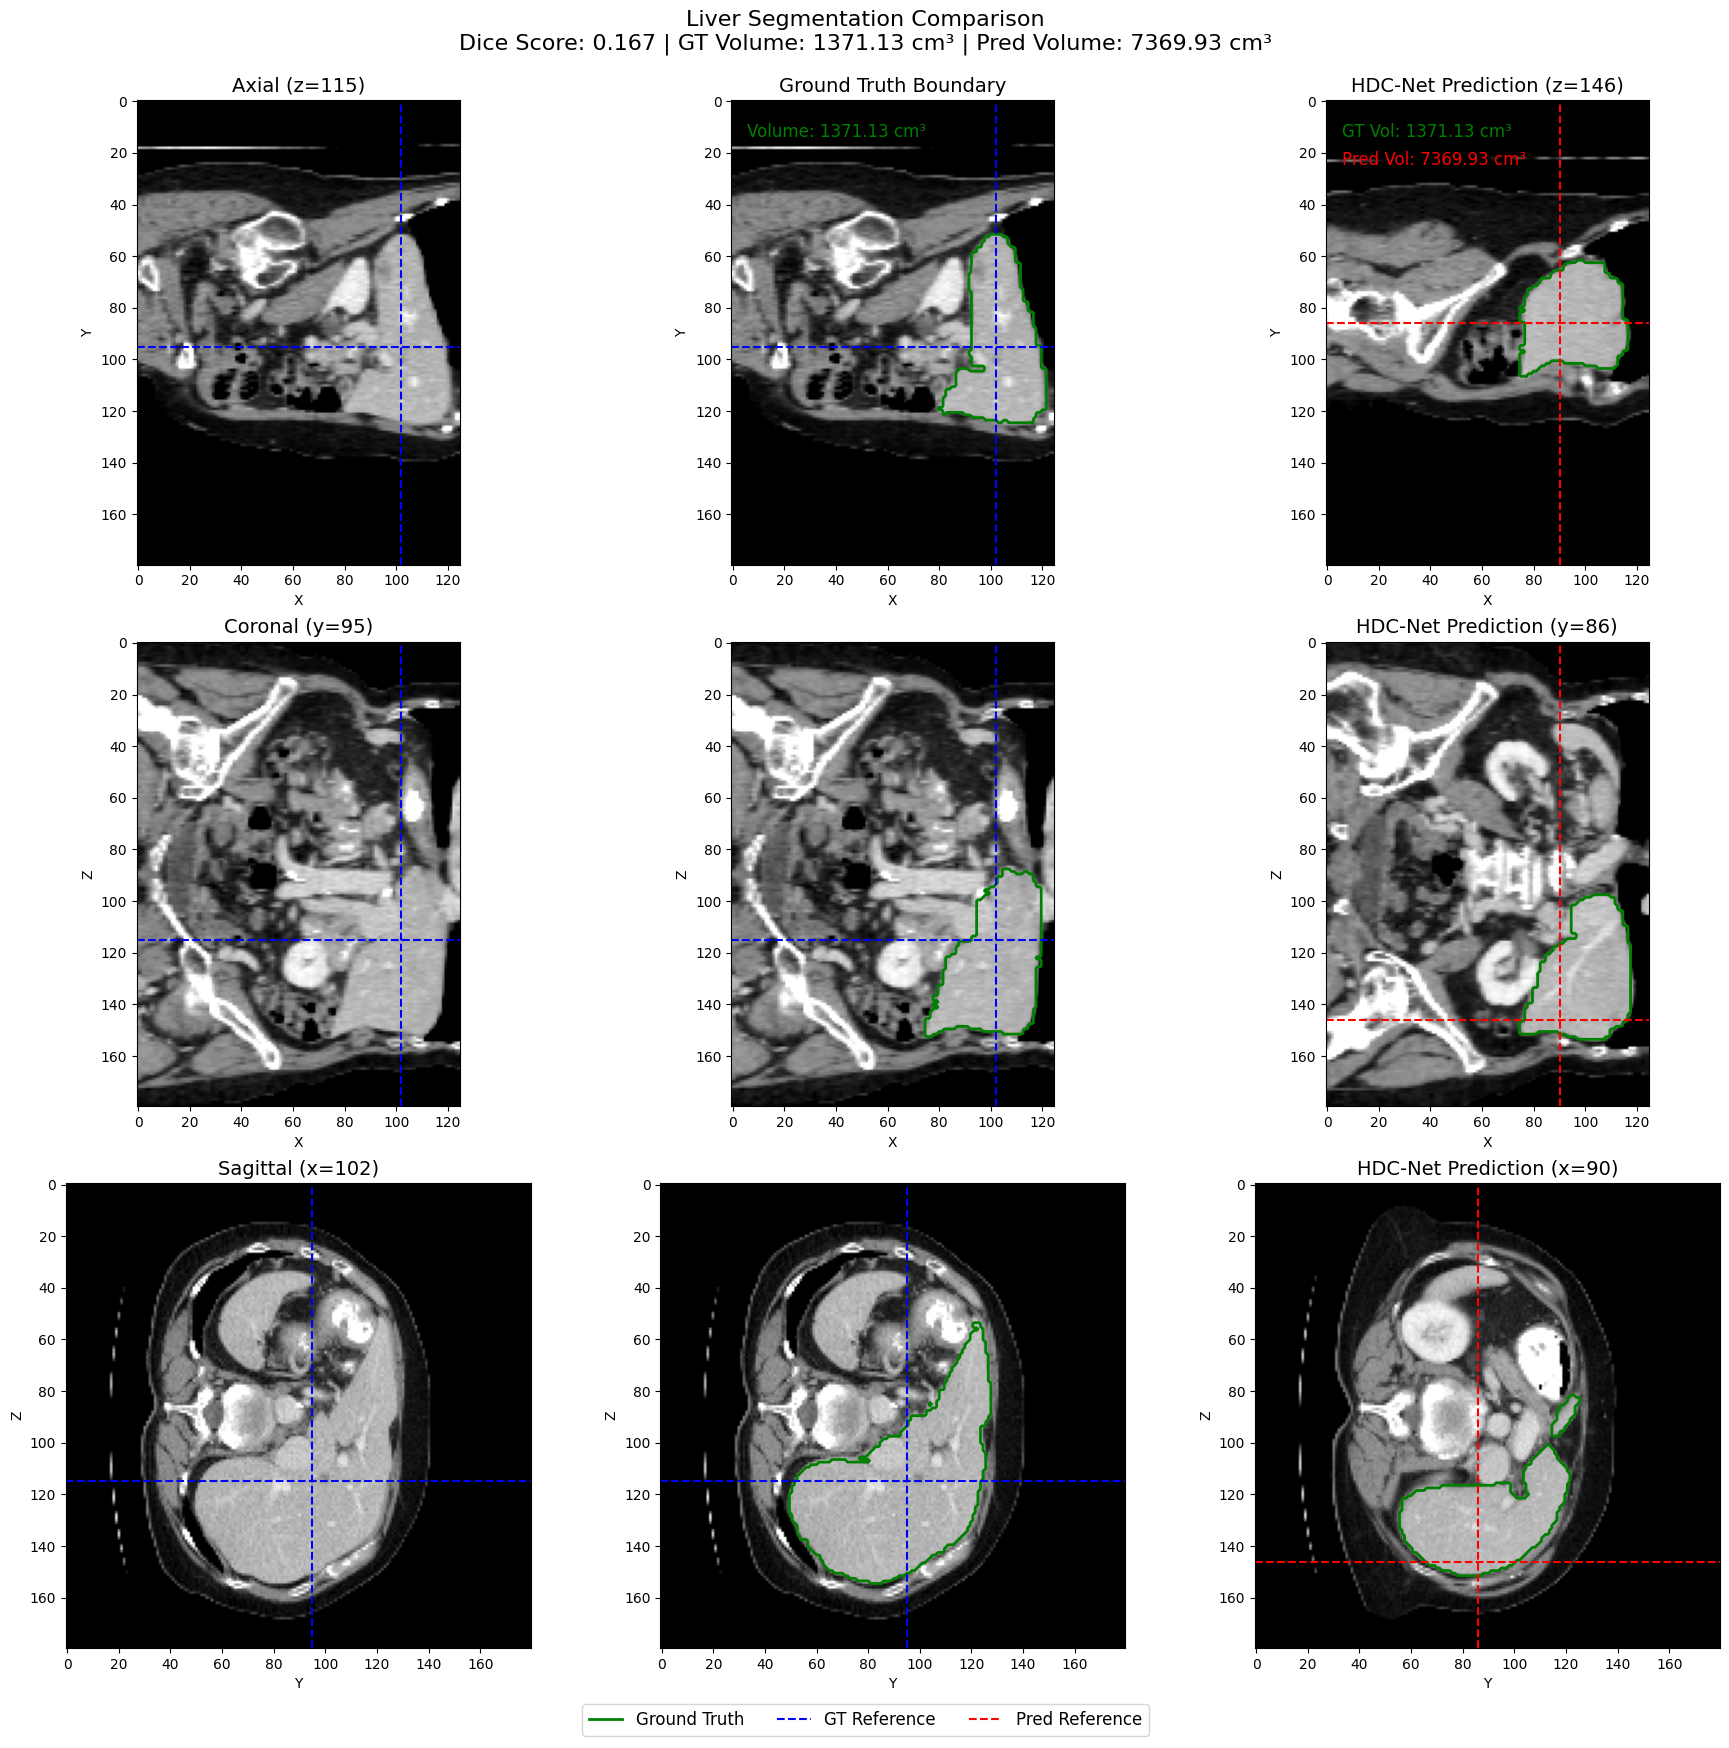

: 

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import matplotlib.patches as patches
from skimage import measure

# -----------------------------
# 1. Load the Data
# -----------------------------
# Original image (e.g., CT scan)
orig_nii = nib.load(r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_0.nii")
orig_data = orig_nii.get_fdata()

# Ground truth label segmentation
label_nii = nib.load(r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_0.nii")
label_data = label_nii.get_fdata()

# Predicted segmentation mask
pred_nii = nib.load(r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_Predicted_Masks\predicted_mask_liver_0.nii.gz")
pred_data = pred_nii.get_fdata()

# -----------------------------
# 2. Resample the Predicted Segmentation
# -----------------------------
orig_shape = orig_data.shape
pred_shape = pred_data.shape

# Compute zoom factors
zoom_factors = (
    orig_shape[0] / pred_shape[0],
    orig_shape[1] / pred_shape[1],
    orig_shape[2] / pred_shape[2]
)

# Use order=1 (linear interpolation) for smoother results
pred_data_resized = zoom(pred_data, zoom_factors, order=1)
# Then threshold to ensure binary segmentation
pred_data_resized = (pred_data_resized > 0.5).astype(float)

# -----------------------------
# 3. Normalize the Original Image for Better Display
# -----------------------------
# Use window-level technique for better CT visualization
def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(img, img_min, img_max)
    windowed_img = (windowed_img - img_min) / (img_max - img_min)
    return windowed_img

# Window settings for abdominal CT (liver)
windowed_img = window_image(orig_data, window_center=50, window_width=350)

# -----------------------------
# 4. Find Centers and Calculate Metrics
# -----------------------------
# Calculate center points for ground truth
gt_indices = np.where(label_data > 0.5)
if len(gt_indices[0]) > 0:
    z_c_gt = int(np.mean(gt_indices[0]))
    y_c_gt = int(np.mean(gt_indices[1]))
    x_c_gt = int(np.mean(gt_indices[2]))
else:
    z_c_gt, y_c_gt, x_c_gt = [s // 2 for s in orig_data.shape]

# Calculate center points for prediction
pred_indices = np.where(pred_data_resized > 0.5)
if len(pred_indices[0]) > 0:
    z_c_pred = int(np.mean(pred_indices[0]))
    y_c_pred = int(np.mean(pred_indices[1]))
    x_c_pred = int(np.mean(pred_indices[2]))
else:
    z_c_pred, y_c_pred, x_c_pred = [s // 2 for s in orig_data.shape]

# Calculate Dice coefficient to quantify overlap
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice_score = dice_coefficient(label_data, pred_data_resized)

# Calculate volumes
voxel_volume = np.prod(orig_nii.header.get_zooms())  # mm³
gt_volume = np.sum(label_data) * voxel_volume / 1000  # Convert to cm³
pred_volume = np.sum(pred_data_resized) * voxel_volume / 1000  # Convert to cm³

# -----------------------------
# 5. Create a 3x3 Grid for Orthogonal Views with Enhanced Visualization
# -----------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
row_titles = ['Axial', 'Coronal', 'Sagittal']
col_titles = ['Original Image', 'Ground Truth Boundary', 'HDC-Net Prediction']

# Set column titles
for col, title in enumerate(col_titles):
    axes[0, col].set_title(title, fontsize=16)

# Function to draw segmentation contours with custom appearance
def draw_segmentation_contours(ax, slice_data, color, linewidth=1.5, linestyle='-'):
    # Find contours at a constant value of 0.5
    contours = measure.find_contours(slice_data, 0.5)
    
    # Plot contours as lines
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth, linestyle=linestyle)

# --- Axial View (fix z = z_c_gt for original and GT, z_c_pred for prediction) ---
# Original Image
axes[0, 0].imshow(windowed_img[z_c_gt, :, :], cmap='gray')
axes[0, 0].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[0, 0].axhline(y=y_c_gt, color='blue', linestyle='--')
axes[0, 0].set_title(f'Axial (z={z_c_gt})', fontsize=14)
axes[0, 0].set_xlabel("X")
axes[0, 0].set_ylabel("Y")

# Ground Truth
axes[0, 1].imshow(windowed_img[z_c_gt, :, :], cmap='gray')
# Add contour of ground truth
draw_segmentation_contours(axes[0, 1], label_data[z_c_gt, :, :], color='green', linewidth=2)
axes[0, 1].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[0, 1].axhline(y=y_c_gt, color='blue', linestyle='--')
axes[0, 1].set_title(f'Ground Truth Boundary', fontsize=14)
axes[0, 1].set_xlabel("X")
axes[0, 1].set_ylabel("Y")
# Add text label for volume
axes[0, 1].text(0.05, 0.95, f"Volume: {gt_volume:.2f} cm³", 
                transform=axes[0, 1].transAxes, color='green', 
                fontsize=12, verticalalignment='top')

# Third column - Ground Truth with Prediction Reference
axes[0, 2].imshow(windowed_img[z_c_pred, :, :], cmap='gray')
# Add contour of ground truth (using the same z-slice as prediction)
draw_segmentation_contours(axes[0, 2], label_data[z_c_pred, :, :], color='green', linewidth=2)
# Add crosshair at prediction center
axes[0, 2].axvline(x=x_c_pred, color='red', linestyle='--')
axes[0, 2].axhline(y=y_c_pred, color='red', linestyle='--')
axes[0, 2].set_title(f'HDC-Net Prediction (z={z_c_pred})', fontsize=14)
axes[0, 2].set_xlabel("X")
axes[0, 2].set_ylabel("Y")
# Add text labels for volumes
axes[0, 2].text(0.05, 0.95, f"GT Vol: {gt_volume:.2f} cm³", 
                transform=axes[0, 2].transAxes, color='green', 
                fontsize=12, verticalalignment='top')
axes[0, 2].text(0.05, 0.89, f"Pred Vol: {pred_volume:.2f} cm³", 
                transform=axes[0, 2].transAxes, color='red', 
                fontsize=12, verticalalignment='top')

# --- Coronal View ---
# Original Image
axes[1, 0].imshow(windowed_img[:, y_c_gt, :], cmap='gray')
axes[1, 0].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[1, 0].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[1, 0].set_title(f'Coronal (y={y_c_gt})', fontsize=14)
axes[1, 0].set_xlabel("X")
axes[1, 0].set_ylabel("Z")

# Ground Truth
axes[1, 1].imshow(windowed_img[:, y_c_gt, :], cmap='gray')
# Add contour of ground truth
draw_segmentation_contours(axes[1, 1], label_data[:, y_c_gt, :], color='green', linewidth=2)
axes[1, 1].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[1, 1].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[1, 1].set_xlabel("X")
axes[1, 1].set_ylabel("Z")

# Third column - Ground Truth with Prediction Reference
axes[1, 2].imshow(windowed_img[:, y_c_pred, :], cmap='gray')
# Add contour of ground truth (using the same y-slice as prediction)
draw_segmentation_contours(axes[1, 2], label_data[:, y_c_pred, :], color='green', linewidth=2)
# Add crosshair at prediction center
axes[1, 2].axvline(x=x_c_pred, color='red', linestyle='--')
axes[1, 2].axhline(y=z_c_pred, color='red', linestyle='--')
axes[1, 2].set_title(f'HDC-Net Prediction (y={y_c_pred})', fontsize=14)
axes[1, 2].set_xlabel("X")
axes[1, 2].set_ylabel("Z")

# --- Sagittal View ---
# Original Image
axes[2, 0].imshow(windowed_img[:, :, x_c_gt], cmap='gray')
axes[2, 0].axvline(x=y_c_gt, color='blue', linestyle='--')
axes[2, 0].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[2, 0].set_title(f'Sagittal (x={x_c_gt})', fontsize=14)
axes[2, 0].set_xlabel("Y")
axes[2, 0].set_ylabel("Z")

# Ground Truth
axes[2, 1].imshow(windowed_img[:, :, x_c_gt], cmap='gray')
# Add contour of ground truth
draw_segmentation_contours(axes[2, 1], label_data[:, :, x_c_gt], color='green', linewidth=2)
axes[2, 1].axvline(x=y_c_gt, color='blue', linestyle='--')
axes[2, 1].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[2, 1].set_xlabel("Y")
axes[2, 1].set_ylabel("Z")

# Third column - Ground Truth with Prediction Reference
axes[2, 2].imshow(windowed_img[:, :, x_c_pred], cmap='gray')
# Add contour of ground truth (using the same x-slice as prediction)
draw_segmentation_contours(axes[2, 2], label_data[:, :, x_c_pred], color='green', linewidth=2)
# Add crosshair at prediction center
axes[2, 2].axvline(x=y_c_pred, color='red', linestyle='--')
axes[2, 2].axhline(y=z_c_pred, color='red', linestyle='--')
axes[2, 2].set_title(f'HDC-Net Prediction (x={x_c_pred})', fontsize=14)
axes[2, 2].set_xlabel("Y")
axes[2, 2].set_ylabel("Z")

# Add a legend at the bottom of the figure
legend_ax = fig.add_axes([0.3, 0.02, 0.4, 0.02])
legend_ax.axis('off')
legend_ax.plot([], [], color='green', linewidth=2, label='Ground Truth')
legend_ax.plot([], [], color='blue', linestyle='--', label='GT Reference')
legend_ax.plot([], [], color='red', linestyle='--', label='Pred Reference')
legend_ax.legend(loc='center', ncol=3, fontsize=12)

# Add metrics as a figure title
plt.suptitle(f"Liver Segmentation Comparison\nDice Score: {dice_score:.3f} | GT Volume: {gt_volume:.2f} cm³ | Pred Volume: {pred_volume:.2f} cm³", 
             fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.07)  # Make room for the title and legend
plt.show()

In [16]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_image(image_path, new_shape=(54, 54, 38)):
    """Load and preprocess a NIfTI image for model prediction"""
    test_image_nifti = nib.load(image_path)
    test_image = test_image_nifti.get_fdata()
    test_image = test_image / np.max(test_image)

    test_image_resized = zoom(test_image, (new_shape[0] / test_image.shape[0], 
                                          new_shape[1] / test_image.shape[1], 
                                          new_shape[2] / test_image.shape[2]), order=1)

    test_image_resized = np.expand_dims(test_image_resized, axis=-1)
    test_image_resized = np.expand_dims(test_image_resized, axis=0)

    return test_image_resized, test_image_nifti

def load_ground_truth_mask(label_path, nifti_obj, new_shape=(54, 54, 38)):
    """Load and preprocess ground truth mask"""
    gt_mask_nifti = nib.load(label_path)
    gt_mask = gt_mask_nifti.get_fdata()

    gt_mask_resized = zoom(gt_mask, (new_shape[0] / gt_mask.shape[0], 
                                     new_shape[1] / gt_mask.shape[1], 
                                     new_shape[2] / gt_mask.shape[2]), order=0)

    return gt_mask_resized

def comprehensive_segmentation_evaluation(model_path, image_path, label_path):
    """
    Perform comprehensive segmentation evaluation
    
    Returns:
    Dictionary of overall metrics and visualization
    """
    # Load the model
    model = load_model(model_path)

    # Prepare lists to store predictions and ground truth
    all_pred_masks = []
    all_gt_masks = []

    # Get list of image files
    image_files = [f for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

    # Process each image
    for image_file in image_files:
        # Construct full paths
        full_image_path = os.path.join(image_path, image_file)
        full_label_path = os.path.join(label_path, image_file)

        # Skip if label doesn't exist
        if not os.path.exists(full_label_path):
            continue

        # Preprocess image
        processed_image, _ = load_and_preprocess_image(full_image_path)

        # Generate prediction
        pred_mask = model.predict(processed_image)
        pred_mask = np.argmax(pred_mask, axis=-1) if pred_mask.ndim > 4 else (pred_mask > 0.5).astype(np.uint8)
        pred_mask = np.squeeze(pred_mask)

        # Load ground truth
        gt_mask = load_ground_truth_mask(full_label_path, nib.load(full_image_path))

        # Store flattened masks
        all_pred_masks.append(pred_mask.flatten())
        all_gt_masks.append(gt_mask.flatten())

    # Combine all predictions and ground truth
    all_pred_flat = np.concatenate(all_pred_masks)
    all_gt_flat = np.concatenate(all_gt_masks)

    # Calculate comprehensive metrics
    metrics = {
        'F1 Score (Macro)': f1_score(all_gt_flat, all_pred_flat, average='macro'),
        'F1 Score (Weighted)': f1_score(all_gt_flat, all_pred_flat, average='weighted'),
        'Precision (Macro)': precision_score(all_gt_flat, all_pred_flat, average='macro'),
        'Precision (Weighted)': precision_score(all_gt_flat, all_pred_flat, average='weighted'),
        'Recall (Macro)': recall_score(all_gt_flat, all_pred_flat, average='macro'),
        'Recall (Weighted)': recall_score(all_gt_flat, all_pred_flat, average='weighted'),
        'Jaccard Index (Macro)': jaccard_score(all_gt_flat, all_pred_flat, average='macro'),
        'Jaccard Index (Weighted)': jaccard_score(all_gt_flat, all_pred_flat, average='weighted')
    }

    # Confusion Matrix
    cm = confusion_matrix(all_gt_flat, all_pred_flat)

    # Visualize metrics
    plt.figure(figsize=(15, 10))

    # Metrics Bar Plot
    plt.subplot(1, 2, 1)
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    plt.bar(metric_names, metric_values)
    plt.title('Segmentation Performance Metrics')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score')
    plt.tight_layout()

    # Confusion Matrix Heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    plt.savefig('segmentation_metrics.png')
    plt.close()

    return metrics

# Paths
model_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5"
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Run comprehensive evaluation
results = comprehensive_segmentation_evaluation(model_path, image_path, label_path)

# Print results
print("\nComprehensive Segmentation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value}")

print("\nMetrics visualization saved as 'segmentation_metrics.png'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\Inayaimtiyaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inayaimtiyaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Comprehensive Segmentation Metrics:
F1 Score (Macro): 0.32892457139693737
F1 Score (Weighted): 0.9610117469863032
Precision (Macro): 0.3246309101961859
Precision (Weighted): 0.9484670506932371
Recall (Macro): 0.3333333333333333
Recall (Weighted): 0.9738927305885577
Jaccard Index (Macro): 0.3246309101961859
Jaccard Index (Weighted): 0.9484670506932371

Metrics visualization saved as 'segmentation_metrics.png'


In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

def load_and_preprocess_data(image_path, label_path):
    """
    Load and preprocess images and labels
    
    Returns:
    X (features), y (labels)
    """
    images = []
    labels = []

    # Get list of image files
    image_files = [f for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

    for image_file in image_files:
        # Construct full paths
        full_image_path = os.path.join(image_path, image_file)
        full_label_path = os.path.join(label_path, image_file)

        # Skip if label doesn't exist
        if not os.path.exists(full_label_path):
            continue

        # Load image
        test_image_nifti = nib.load(full_image_path)
        test_image = test_image_nifti.get_fdata()

        # Load label
        label_nifti = nib.load(full_label_path)
        label = label_nifti.get_fdata()

        # Normalize and flatten
        test_image = test_image / np.max(test_image)
        test_image_flat = test_image.flatten()
        label_flat = label.flatten()

        images.append(test_image_flat)
        labels.append(label_flat)

    # Combine all images and labels
    X = np.array(images)
    y = np.array(labels).flatten()

    return X, y

def evaluate_models(X, y):
    """
    Evaluate multiple models and return their metrics
    
    Args:
    X: Features
    y: Labels
    
    Returns:
    Dictionary of model metrics
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'SVM': SVC(probability=True)
    }

    # Metrics to calculate
    metrics = {}

    # Evaluate each model
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        model_metrics = {
            'F1 Score': f1_score(y_test, y_pred, average='binary'),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Mean Squared Error': mean_squared_error(y_test, y_pred)
        }
        
        metrics[name] = model_metrics

    return metrics

# Paths
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Load and preprocess data
X, y = load_and_preprocess_data(image_path, label_path)

# Evaluate models
metrics = evaluate_models(X, y)

# Print metrics
print("Model Performance Metrics:")
for model, model_metrics in metrics.items():
    print(f"\n{model}:")
    for metric, value in model_metrics.items():
        print(f"{metric}: {value}")


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

def count_model_layers(model_path):
    """
    Count total layers and hidden layers in a Keras model
    
    Args:
    model_path: Path to the saved Keras model
    """
    # Load the model
    model = load_model(model_path)
    
    # Total number of layers
    total_layers = len(model.layers)
    
    # Count hidden layers (excluding input and output layers)
    hidden_layers = 0
    for layer in model.layers:
        # Exclude input layers and layers that don't perform computation
        if not isinstance(layer, (tf.keras.layers.InputLayer, 
                                  tf.keras.layers.Dropout, 
                                  tf.keras.layers.BatchNormalization)):
            hidden_layers += 1
    
    print("Total Number of Layers:", total_layers)
    print("Number of Hidden Layers:", hidden_layers)

# Path to your model
model_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5"

# Run the layer counting
count_model_layers(model_path)

Total Number of Layers: 50
Number of Hidden Layers: 43


In [9]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom

def calculate_segmentation_metrics(gt_mask, pred_mask):
    """
    Calculate segmentation performance metrics
    
    Args:
    gt_mask: Ground truth mask
    pred_mask: Predicted mask
    
    Returns:
    Dictionary of performance metrics
    """
    # Ensure masks are binary
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)
    
    # Calculate True Positives, False Positives, False Negatives, True Negatives
    TP = np.sum((gt_mask == 1) & (pred_mask == 1))
    FP = np.sum((gt_mask == 0) & (pred_mask == 1))
    FN = np.sum((gt_mask == 1) & (pred_mask == 0))
    TN = np.sum((gt_mask == 0) & (pred_mask == 0))
    
    # Dice Coefficient
    dice = 2 * TP / (2 * TP + FP + FN)
    
    # Intersection over Union (IoU)
    iou = TP / (TP + FP + FN)
    
    # Sensitivity (Recall)
    sensitivity = TP / (TP + FN)
    
    # Specificity
    specificity = TN / (TN + FP)
    
    return {
        'Dice': dice,
        'IoU': iou,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

def evaluate_model_performance(model_path, image_path, label_path):
    """
    Evaluate model performance for a single model
    
    Args:
    model_path: Path to the trained model
    image_path: Directory with input images
    label_path: Directory with ground truth labels
    
    Returns:
    Dictionary of average performance metrics
    """
    # Load the model
    model = load_model(model_path)
    
    # Initialize metrics accumulators
    total_metrics = {
        'Dice': 0,
        'IoU': 0,
        'Sensitivity': 0,
        'Specificity': 0
    }
    
    # Get list of image files
    image_files = [f for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    # Counter for number of processed images
    image_count = 0
    
    # Process each image
    for image_file in image_files:
        # Construct full paths
        full_image_path = os.path.join(image_path, image_file)
        full_label_path = os.path.join(label_path, image_file)
        
        # Skip if label doesn't exist
        if not os.path.exists(full_label_path):
            continue
        
        # Load image
        test_image_nifti = nib.load(full_image_path)
        test_image = test_image_nifti.get_fdata()
        
        # Normalize image
        test_image = test_image / np.max(test_image)
        
        # Resize image to model input shape
        new_shape = (54, 54, 38)
        test_image_resized = zoom(test_image, (new_shape[0] / test_image.shape[0], 
                                               new_shape[1] / test_image.shape[1], 
                                               new_shape[2] / test_image.shape[2]), order=1)
        
        # Prepare image for prediction
        test_image_resized = np.expand_dims(test_image_resized, axis=-1)
        test_image_resized = np.expand_dims(test_image_resized, axis=0)
        
        # Load ground truth
        gt_mask_nifti = nib.load(full_label_path)
        gt_mask = gt_mask_nifti.get_fdata()
        
        # Resize ground truth mask
        gt_mask_resized = zoom(gt_mask, (new_shape[0] / gt_mask.shape[0], 
                                         new_shape[1] / gt_mask.shape[1], 
                                         new_shape[2] / gt_mask.shape[2]), order=0)
        
        # Predict
        pred_mask = model.predict(test_image_resized)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        pred_mask = np.squeeze(pred_mask)
        
        # Calculate metrics for this image
        image_metrics = calculate_segmentation_metrics(gt_mask_resized, pred_mask)
        
        # Accumulate metrics
        for metric in total_metrics:
            total_metrics[metric] += image_metrics[metric]
        
        image_count += 1
    
    # Calculate average metrics
    if image_count > 0:
        for metric in total_metrics:
            total_metrics[metric] /= image_count
    
    return total_metrics

# Paths
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# HDC Net model path
hdc_net_model = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5"

# Evaluate HDC Net performance
print("HDC Net Segmentation Performance Metrics:")
hdc_net_metrics = evaluate_model_performance(hdc_net_model, image_path, label_path)

# Print metrics
print(f"Dice: {hdc_net_metrics['Dice']:.4f}")
print(f"IoU: {hdc_net_metrics['IoU']:.4f}")
print(f"Sensitivity: {hdc_net_metrics['Sensitivity']:.4f}")
print(f"Specificity: {hdc_net_metrics['Specificity']:.4f}")

HDC Net Segmentation Performance Metrics:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

def count_model_layers(model_path):
    """
    Count total layers and hidden layers in a Keras model
    
    Args:
    model_path: Path to the saved Keras model
    
    Returns:
    Tuple of (total layers, hidden layers)
    """
    # Load the model
    model = load_model(model_path)
    
    # Total number of layers
    total_layers = len(model.layers)
    
    # Count hidden layers (excluding input and output layers)
    hidden_layers = 0
    for layer in model.layers:
        # Exclude input layers and layers that don't perform computation
        if not isinstance(layer, (tf.keras.layers.InputLayer, 
                                  tf.keras.layers.Dropout, 
                                  tf.keras.layers.BatchNormalization,
                                  tf.keras.layers.Activation)):
            hidden_layers += 1
    
    return total_layers, hidden_layers

# List of model paths
model_paths = [
    r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\HDC_net_60epochs.h5",
    r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\3d_unet_model_20epochs.h5",
    r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Vnet_20epochs.h5"
]

# Model names (for clearer output)
model_names = [
    "HDC Net",
    "3D U-Net",
    "V-Net"
]

# Run layer counting for each model
print("Model Layer Analysis:")
print("-" * 30)

for path, name in zip(model_paths, model_names):
    try:
        total, hidden = count_model_layers(path)
        print(f"{name} Model:")
        print(f"  Total Layers: {total}")
        print(f"  Hidden Layers: {hidden}")
        print("-" * 30)
    except Exception as e:
        print(f"Error processing {name} model: {e}")
        print("-" * 30)

Model Layer Analysis:
------------------------------
HDC Net Model:
  Total Layers: 50
  Hidden Layers: 43
------------------------------


3D U-Net Model:
  Total Layers: 11
  Hidden Layers: 10
------------------------------
V-Net Model:
  Total Layers: 11
  Hidden Layers: 10
------------------------------


In [8]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, new_shape=(54, 54, 38)):
    """Load and preprocess a NIfTI image for model prediction"""
    test_image_nifti = nib.load(image_path)
    test_image = test_image_nifti.get_fdata()
    test_image = test_image / np.max(test_image)

    test_image_resized = zoom(test_image, (new_shape[0] / test_image.shape[0], 
                                          new_shape[1] / test_image.shape[1], 
                                          new_shape[2] / test_image.shape[2]), order=1)

    test_image_resized = np.expand_dims(test_image_resized, axis=-1)
    test_image_resized = np.expand_dims(test_image_resized, axis=0)

    return test_image_resized, test_image_nifti

def load_ground_truth_mask(label_path, nifti_obj, new_shape=(54, 54, 38)):
    """Load and preprocess ground truth mask"""
    gt_mask_nifti = nib.load(label_path)
    gt_mask = gt_mask_nifti.get_fdata()

    gt_mask_resized = zoom(gt_mask, (new_shape[0] / gt_mask.shape[0], 
                                     new_shape[1] / gt_mask.shape[1], 
                                     new_shape[2] / gt_mask.shape[2]), order=0)

    return gt_mask_resized

def evaluate_hdc_model_accuracy(model_path, image_path, label_path):
    """
    Evaluate HDC model accuracy only
    
    Returns:
    Overall accuracy and per-image accuracies
    """
    # Load the model
    model = load_model(model_path)

    # Prepare lists to store predictions and ground truth
    all_pred_masks = []
    all_gt_masks = []
    accuracies = {}

    # Get list of image files
    image_files = [f for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

    print(f"Found {len(image_files)} image files for evaluation.")

    # Process each image
    for image_file in image_files:
        # Construct full paths
        full_image_path = os.path.join(image_path, image_file)
        full_label_path = os.path.join(label_path, image_file)

        # Skip if label doesn't exist
        if not os.path.exists(full_label_path):
            print(f"Skipping {image_file} - no matching label found.")
            continue

        print(f"Processing image: {image_file}")

        # Preprocess image
        processed_image, _ = load_and_preprocess_image(full_image_path)

        # Generate prediction
        pred_mask = model.predict(processed_image, verbose=0)
        pred_mask = np.argmax(pred_mask, axis=-1) if pred_mask.ndim > 4 else (pred_mask > 0.5).astype(np.uint8)
        pred_mask = np.squeeze(pred_mask)

        # Load ground truth
        gt_mask = load_ground_truth_mask(full_label_path, nib.load(full_image_path))

        # Calculate per-image accuracy
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask.flatten()
        
        # Ensure both masks have the same shape
        if pred_flat.shape != gt_flat.shape:
            print(f"Warning: Shape mismatch for {image_file}. Pred: {pred_flat.shape}, GT: {gt_flat.shape}")
            min_length = min(len(pred_flat), len(gt_flat))
            pred_flat = pred_flat[:min_length]
            gt_flat = gt_flat[:min_length]
        
        # Calculate accuracy for this image
        img_accuracy = accuracy_score(gt_flat, pred_flat)
        accuracies[image_file] = img_accuracy
        
        print(f"Accuracy for {image_file}: {img_accuracy:.4f}")

        # Store flattened masks for overall accuracy
        all_pred_masks.append(pred_flat)
        all_gt_masks.append(gt_flat)

    # Combine all predictions and ground truth
    all_pred_flat = np.concatenate(all_pred_masks)
    all_gt_flat = np.concatenate(all_gt_masks)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_gt_flat, all_pred_flat)
    
    # Visualize accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('HDC Model Accuracy per Image')
    plt.xticks(rotation=90)
    plt.ylabel('Accuracy')
    plt.axhline(y=overall_accuracy, color='r', linestyle='-', label=f'Overall Accuracy: {overall_accuracy:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('hdc_model_accuracy.png')
    plt.close()

    print(f"\nOverall Model Accuracy: {overall_accuracy:.4f}")
    print(f"Per-image accuracy visualization saved as 'hdc_model_accuracy.png'")
    
    return overall_accuracy, accuracies

# Paths (use your original paths)
model_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\SavedModels\HDC_net_60epochs.h5"
image_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Run accuracy evaluation
overall_accuracy, per_image_accuracies = evaluate_hdc_model_accuracy(model_path, image_path, label_path)

Found 123 image files for evaluation.
Processing image: liver_0.nii
Accuracy for liver_0.nii: 0.9729
Processing image: liver_1.nii
Accuracy for liver_1.nii: 0.9798
Processing image: liver_10.nii
Accuracy for liver_10.nii: 0.9791
Processing image: liver_101.nii
Accuracy for liver_101.nii: 0.9637
Processing image: liver_102.nii
Accuracy for liver_102.nii: 0.9726
Processing image: liver_104.nii
Accuracy for liver_104.nii: 0.9847
Processing image: liver_105.nii
Accuracy for liver_105.nii: 0.9872
Processing image: liver_106.nii
Accuracy for liver_106.nii: 0.9889
Processing image: liver_107.nii
Accuracy for liver_107.nii: 0.9850
Processing image: liver_108.nii
Accuracy for liver_108.nii: 0.9791
Processing image: liver_109.nii
Accuracy for liver_109.nii: 0.9852
Processing image: liver_11.nii
Accuracy for liver_11.nii: 0.9747
Processing image: liver_110.nii
Accuracy for liver_110.nii: 0.9860
Processing image: liver_111.nii
Accuracy for liver_111.nii: 0.9779
Processing image: liver_112.nii
Accu

In [ ]:
# Distribution of 80-20 data set gave accuracy of 97.39% while 70-30 gave less.